In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [36]:
np.random.seed(10)

steps = np.random.standard_normal(500) # 정규분포에서 500개의 난수 생성
steps[0] = 0

random_walk = np.cumsum(steps) # 각 시간 단계의 오차에 대한 누적 합계

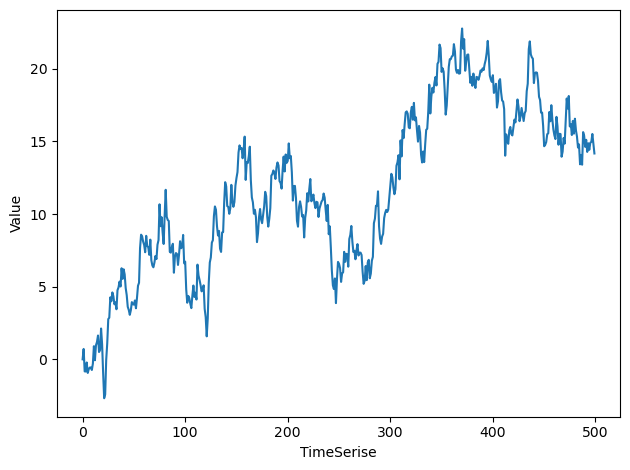

In [37]:
#시뮬레이션 된 확률보행 도식화
fig, ax = plt.subplots()

ax.plot(random_walk)
ax.set_xlabel('TimeSerise')
ax.set_ylabel('Value')

plt.tight_layout()

In [38]:
#정상성 테스트
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(random_walk) # ADF 테스트

print(f'ADF statistic: {ADF_result[0]}') # -0.59는 크지 않은 음수
print(f'p-value: {ADF_result[1]}') # 0.05 < 0.8 이므로 귀무가설 기각 못함. 즉 비정상적이다. 

ADF statistic: -2.3868621253974727
p-value: 0.14547886225420392


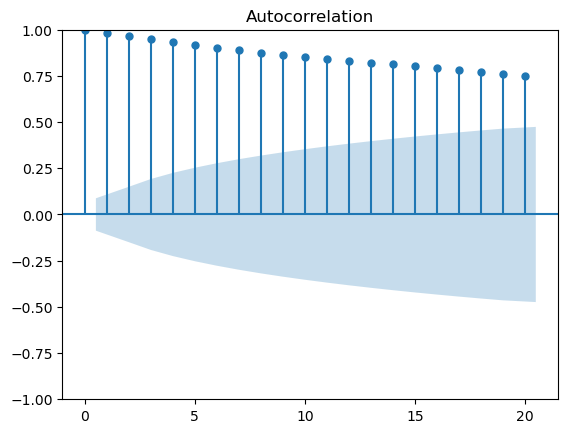

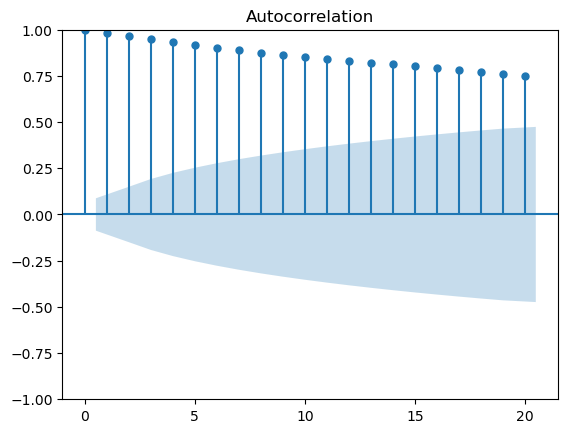

In [39]:
#ACF 도식화
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(random_walk, lags = 20)

In [40]:
# 정상화를 위한 1차 차분
diff_random_walk = np.diff(random_walk, n=1) #n은 차분 횟수

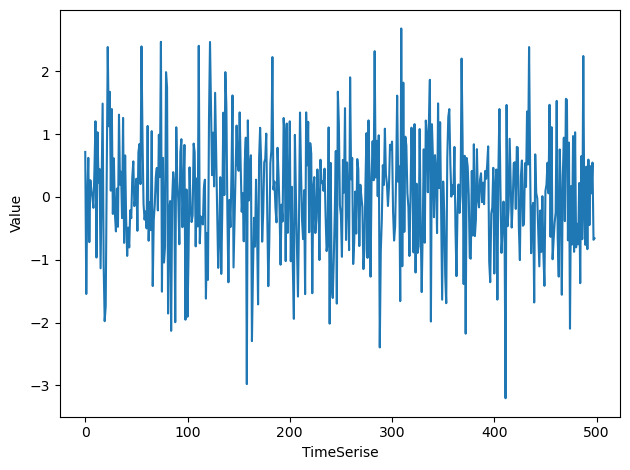

In [41]:
#차분 데이터 시각화
fig, ax = plt.subplots()

ax.plot(diff_random_walk)
ax.set_xlabel('TimeSerise')
ax.set_ylabel('Value')

plt.tight_layout()

In [42]:
#차분 데이터 ADF 테스트
ADF_result = adfuller(diff_random_walk)

print(f'ADF statistic: {ADF_result[0]}') # -21은 큰 음수
print(f'p-value: {ADF_result[1]}') # 0.05 > 0.0 이므로 귀무가설 기각 가능. 즉, 정상적이다. 

ADF statistic: -23.67413778224835
p-value: 0.0


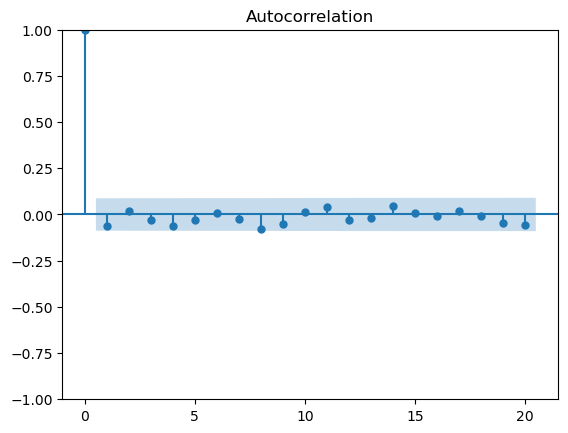

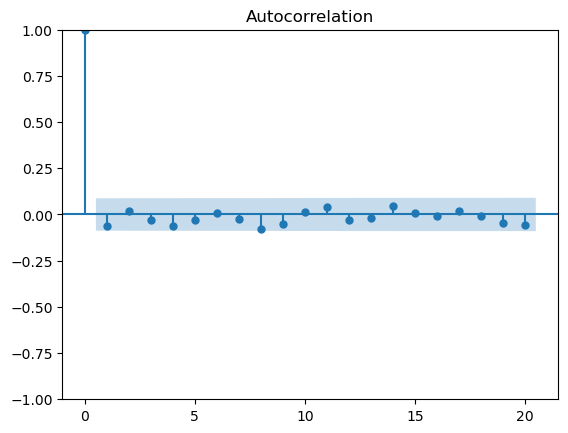

In [43]:
#차분 데이터 ACF
plot_acf(diff_random_walk, lags=20)

In [44]:
#확률보행 예측하기
df = pd.DataFrame({'value':random_walk})
train = df[:400]
test = df[400:]

In [45]:
#과거 기간의 평균으로 예측
mean = np.mean(train.value)
test.loc[:, 'pred_mean'] = mean
test.head()

/tmp/ipykernel_18506/1107844274.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_mean'] = mean


,value,pred_mean
400,19.560720,10.361924
401,18.340865,10.361924
402,18.533438,10.361924
403,18.968888,10.361924
404,17.333944,10.361924


In [46]:
#마지막으로 측정된 값
last_value = train.iloc[-1].value
test.loc[:, 'pred_last'] = last_value
test.head()

/tmp/ipykernel_18506/2970750832.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last'] = last_value


,value,pred_mean,pred_last
400,19.560720,10.361924,19.098335
401,18.340865,10.361924,19.098335
402,18.533438,10.361924,19.098335
403,18.968888,10.361924,19.098335
404,17.333944,10.361924,19.098335


In [47]:
#표류(drift)
drift = (last_value - train.iloc[0].value) / (400-1)

x_vals = np.arange(401, 501, 1)
pred_drift = drift * x_vals # 각 시간 단계에 표류값을 곱하여 각 시간 단계에 대한 예측값을 구한다.

test.loc[:, 'pred_drift'] = pred_drift
test.head()

/tmp/ipykernel_18506/1804892925.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_drift'] = pred_drift


,value,pred_mean,pred_last,pred_drift
400,19.560720,10.361924,19.098335,19.194066
401,18.340865,10.361924,19.098335,19.241931
402,18.533438,10.361924,19.098335,19.289797
403,18.968888,10.361924,19.098335,19.337662
404,17.333944,10.361924,19.098335,19.385528


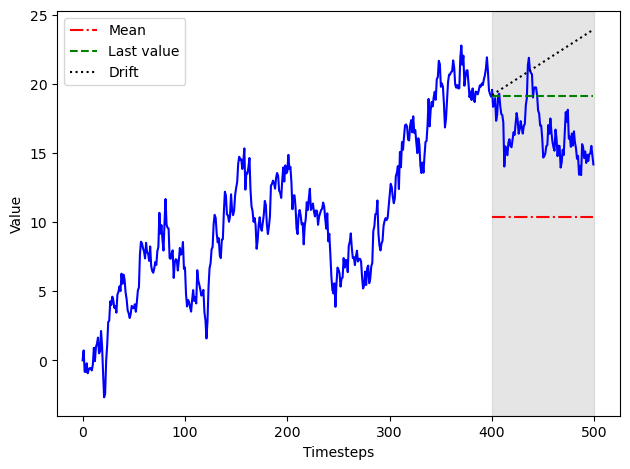

In [49]:
#예측값들 도식화
fig, ax = plt.subplots()

ax.plot(train.value, 'b-')
ax.plot(test['value'], 'b-')
ax.plot(test['pred_mean'], 'r-.', label='Mean')
ax.plot(test['pred_last'], 'g--', label='Last value')
ax.plot(test['pred_drift'], 'k:', label='Drift')

ax.axvspan(400, 500, color='#808080', alpha = 0.2)
ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

In [51]:
#MSE
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last'])
mse_drift = mean_squared_error(test['value'], test['pred_drift'])
print(mse_mean, mse_last, mse_drift)

42.36660758420728 9.701982748219805 32.69990654548667


연습문제 2: 구글 일일 종가 예측

In [80]:
df = pd.read_csv('../다운로드/GOOGL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-27,1292.000000,1294.099976,1265.060059,1270.859985,1270.859985,2209300
1,2020-04-28,1283.199951,1284.760010,1230.380005,1232.589966,1232.589966,4035000
2,2020-04-29,1345.000000,1360.150024,1326.729980,1342.180054,1342.180054,5417900
3,2020-04-30,1331.359985,1350.000000,1321.500000,1346.699951,1346.699951,2792100
4,2020-05-01,1324.089966,1351.430054,1309.660034,1317.319946,1317.319946,2443600


In [93]:
train = list(df['Close'][:-5])
test = df['Close'][-5:]
test = pd.DataFrame(test)

In [94]:
#평균값 예측
pred_mean = np.mean(train)
test.loc[:, 'pred_mean'] = pred_mean

In [96]:
#마지막값 예측
pred_last = train[-1]
test.loc[:, 'pred_last'] = pred_last

In [102]:
#표류 예측
drift = (pred_last - train[0]) / len(train) - 1

x_vals = np.arange(len(train), len(train)+5, 1)

pred_drift = drift*x_vals

test.loc[:, 'pred_drift'] = pred_drift
test

,Close,pred_mean,pred_last,pred_drift
248,2278.350098,1689.993184,2279.01001,760.150025
249,2252.520020,1689.993184,2279.01001,763.215146
250,2299.929932,1689.993184,2279.01001,766.280267
251,2309.929932,1689.993184,2279.01001,769.345388
252,2290.979980,1689.993184,2279.01001,772.410509


In [103]:
#MSE
mse_mean = mean_squared_error(test['Close'], test['pred_mean'])
mse_last = mean_squared_error(test['Close'], test['pred_last'])
mse_drift = mean_squared_error(test['Close'], test['pred_drift'])
print(mse_mean, mse_last, mse_drift)

356025.96701539395 447.82398976418415 2310899.147541159


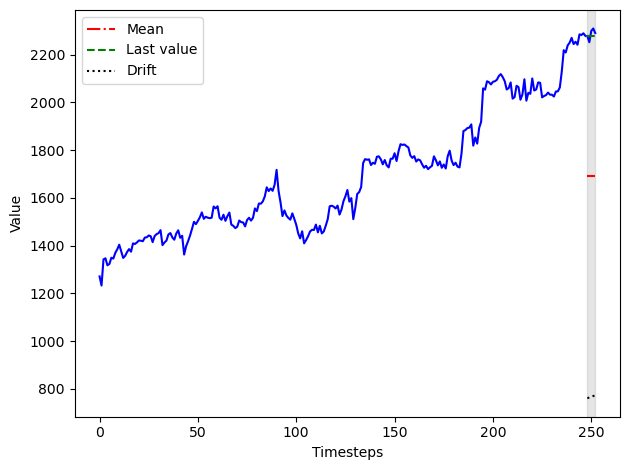

In [108]:
#예측값들 도식화
fig, ax = plt.subplots()

ax.plot(train, 'b-')
ax.plot(test['Close'], 'b-')
ax.plot(test['pred_mean'], 'r-.', label='Mean')
ax.plot(test['pred_last'], 'g--', label='Last value')
ax.plot(test['pred_drift'], 'k:', label='Drift')

ax.axvspan(248, 252, color='#808080', alpha = 0.2)
ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

In [262]:
#삼성전자 일일 종가 예측하기
import yfinance as yf

# 삼성전자 주식 데이터 다운로드
ticker = '005930.KS'
data = yf.download(ticker, start='2024-02-18', end='2025-02-18')

# 데이터 CSV 파일로 저장
data.to_csv('samsung_stock_data.csv')


[*********************100%***********************]  1 of 1 completed


In [114]:
df['Close'].head()

Ticker,005930.KS
Date,
2024-02-19,72239.265625
2024-02-20,71749.843750
2024-02-21,71456.179688
2024-02-22,71554.070312
2024-02-23,71358.296875


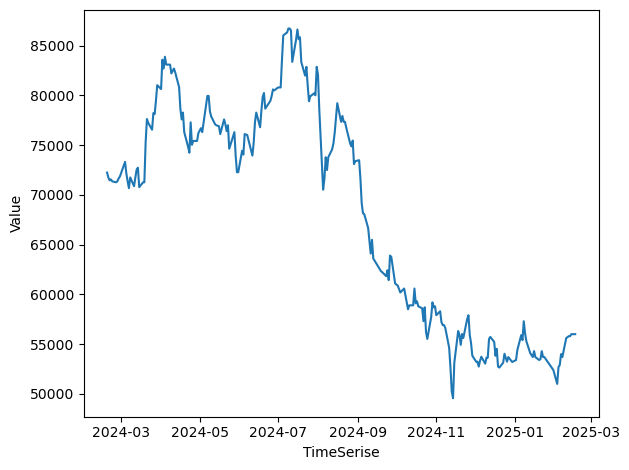

In [115]:
#도식화
fig, ax = plt.subplots()

ax.plot(df.Close)
ax.set_xlabel('TimeSerise')
ax.set_ylabel('Value')

plt.tight_layout()

In [118]:
#확률보행 확인
#정상성 테스트
ADF_result = adfuller(df['Close']) # ADF 테스트

print(f'ADF statistic: {ADF_result[0]}') # -0.69는 크지 않은 음수
print(f'p-value: {ADF_result[1]}') # 0.05 < 0.8 이므로 귀무가설 기각 못함. 즉 비정상적이다. 

ADF statistic: -0.6934179646837382
p-value: 0.8484470747368158


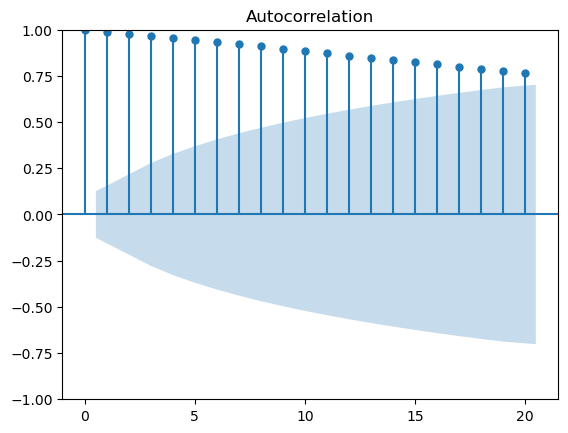

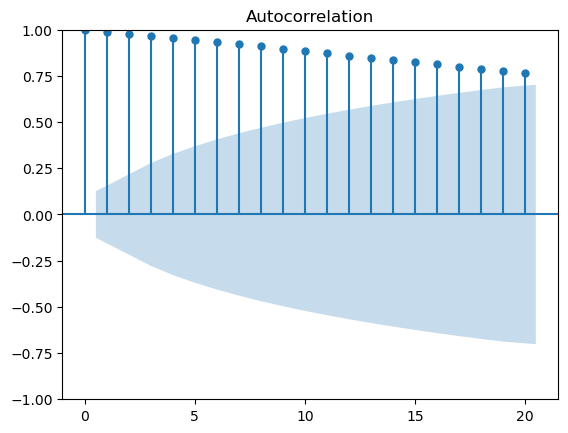

In [119]:
#ACF 도식화
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df['Close'], lags = 20)

In [138]:
# 정상화를 위한 1차 차분
samsung = np.diff(df['Close'].squeeze(), n=1) #n은 차분 횟수

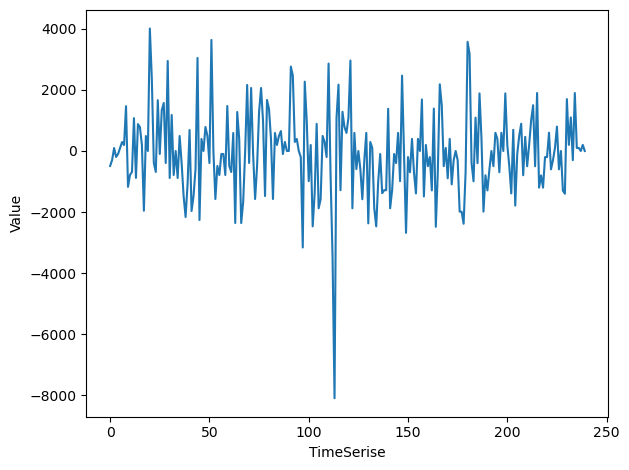

In [142]:
#차분 데이터 시각화
fig, ax = plt.subplots()

ax.plot(samsung)
ax.set_xlabel('TimeSerise')
ax.set_ylabel('Value')

plt.tight_layout()

In [143]:
#차분 데이터 ADF 테스트
ADF_result = adfuller(samsung)

print(f'ADF statistic: {ADF_result[0]}') # -14는 큰 음수
print(f'p-value: {ADF_result[1]}') # 0.05 > 0.000000000000---7

ADF statistic: -14.44097631431347
p-value: 7.360404146548146e-27


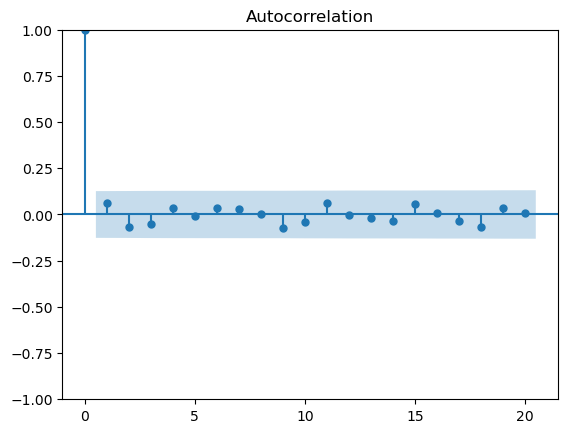

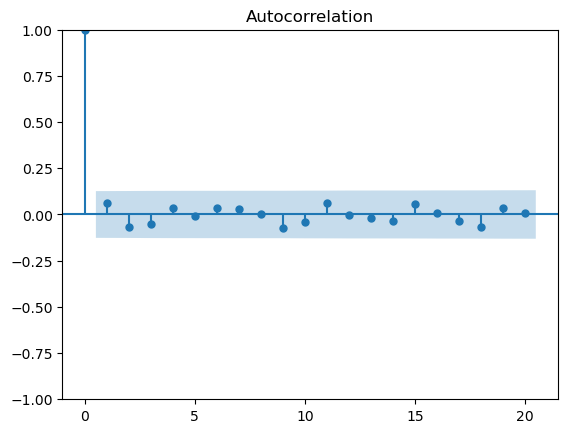

In [144]:
#차분 데이터 ACF
plot_acf(samsung, lags=20)

In [241]:
train = pd.DataFrame()
train.loc[:, 'value'] = df['Close'].squeeze()[:-5]
test = pd.DataFrame()
test.loc[:, 'value'] = df['Close'].squeeze()[-5:]

In [242]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [243]:
train = train['value'].values

In [244]:
pred_mean = np.mean(train)
test.loc[:, 'pred_mean'] = pred_mean
test.head()

,value,pred_mean
0,55700.0,68584.949219
1,55800.0,68584.949219
2,55800.0,68584.949219
3,56000.0,68584.949219
4,56000.0,68584.949219


In [245]:
pred_last = train[-1]
test.loc[:, 'pred_last'] = pred_last
test.head()

,value,pred_mean,pred_last
0,55700.0,68584.949219,55600.0
1,55800.0,68584.949219,55600.0
2,55800.0,68584.949219,55600.0
3,56000.0,68584.949219,55600.0
4,56000.0,68584.949219,55600.0


In [246]:
drift = pred_last - train[0] / len(train) - 1

x_vals = np.arange(len(train), len(train)+5, 1)
pred_drift = x_vals * drift

test.loc[:, 'pred_drift'] = pred_drift
test.head()

,value,pred_mean,pred_last,pred_drift
0,55700.0,68584.949219,55600.0,1.304912e+07
1,55800.0,68584.949219,55600.0,1.310442e+07
2,55800.0,68584.949219,55600.0,1.315971e+07
3,56000.0,68584.949219,55600.0,1.321500e+07
4,56000.0,68584.949219,55600.0,1.327030e+07


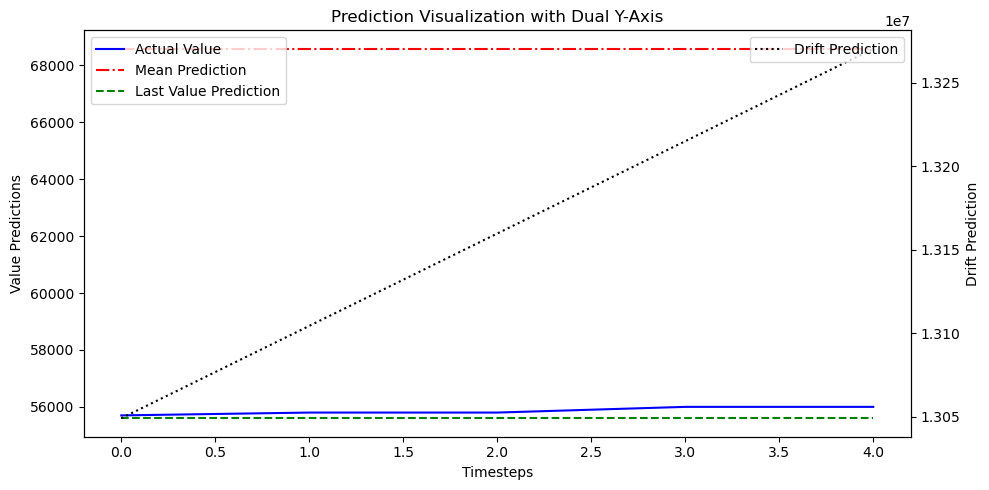

In [260]:
import matplotlib.pyplot as plt
import pandas as pd

# 데이터 생성
data = {
    'value': [55700.0, 55800.0, 55800.0, 56000.0, 56000.0],
    'pred_mean': [68584.949219] * 5,
    'pred_last': [55600.0] * 5,
    'pred_drift': [1.304912e+07, 1.310442e+07, 1.315971e+07, 1.321500e+07, 1.327030e+07]
}
test = pd.DataFrame(data)
test.index = range(len(test))  # 인덱스 설정

# 시각화
fig, ax1 = plt.subplots(figsize=(10, 5))

# 첫 번째 y축 (value, pred_mean, pred_last)
ax1.plot(test.index, test['value'], 'b-', label='Actual Value')
ax1.plot(test.index, test['pred_mean'], 'r-.', label='Mean Prediction')
ax1.plot(test.index, test['pred_last'], 'g--', label='Last Value Prediction')

ax1.set_ylabel('Value Predictions')
ax1.set_xlabel('Timesteps')
ax1.legend(loc='upper left')

# 두 번째 y축 (pred_drift)
ax2 = ax1.twinx()
ax2.plot(test.index, test['pred_drift'], 'k:', label='Drift Prediction')
ax2.set_ylabel('Drift Prediction')
ax2.legend(loc='upper right')

plt.title('Prediction Visualization with Dual Y-Axis')
plt.tight_layout()
plt.show()


In [261]:
#MSE
mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last'])
mse_drift = mean_squared_error(test['value'], test['pred_drift'])
print(mse_mean, mse_last, mse_drift)

161938732.62612876 82000.0 171716981995780.0
